In [40]:
# We first import all necessary libraries, the dataset itself, and start a DB session.

from datetime import datetime, timedelta

from crowdplay_datasets.dataset import get_trajectory_by_id, get_engine_and_session, EpisodeModel, UserModel, EnvironmentModel, EnvironmentKeywordDataModel, EpisodeKeywordDataModel

_, session = get_engine_and_session("crowdplay_atari-v0")

# Shorthand for the agent key of the first agent in any of our environments.
P0 = 'game_0>player_0'

In [41]:
# Next, we load all the episodes, users and environments, for further filtering in Python.
# This will take around 10-15 seconds.
all_episodes = session.query(EpisodeModel).all()
all_users = session.query(UserModel).all()
all_environments = session.query(EnvironmentModel).all()

In [42]:
# Let's examine what an episode looks like!
ep = all_episodes[0]
print(ep)

# We see that the episode has a unique ID, it is referencing an environment also with a unique ID, 
# and it has a nested dictionary of key-value metadata for the episode as a whole and for each player.

<Episode(episode_id=07e25c0f367744e6b5b496d64f2ff203, environment_id=00173bf930574f68967423935093b494, kwdata={'all': {'created_on': datetime.datetime(2021, 10, 2, 13, 49, 31)}, 'game_0>player_0': {'Active playtime': datetime.timedelta(seconds=55), 'Correct aliens shot (fraction)': 0.4, 'Correct aliens shot (total)': 6, 'Score': 190, 'Time played': datetime.timedelta(seconds=55)}}>


In [43]:
# We can also get the trajectory for this episode. 
# Let's first look at the raw data.

trajectory = ep.get_raw_trajectory()
print(trajectory[0])

# We see that each step in the trajectory contains the observation for all agents, the actions, and a lot of metadata.

{'prev_obs': {'game_0>player_0': OrderedDict([('image', array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]],

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]],

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]]], dtype=uint8))])}, 'action': {'game_0>player_0': {

In [44]:
# For downstream offline learning pipelines we might not want all of this data.
# And we might prefer the observations to be in a preprocessed form as they would come in a deepmind-wrapped Gym Atari environment.
# The episode object provides a method for that too!
# We can get the trajectory as a list of preprocessed observations and a separate list of actions. 

processed_trajectory = ep.get_processed_trajectory()
print(processed_trajectory[0][:3])
print(processed_trajectory[1][:3])


[array([[[ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        ...,
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0]],

       [[ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        ...,
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0]],

       [[ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        ...,
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0]],

       ...,

       [[ 0,  0,  0, 79],
        [ 0,  0,  0, 79],
        [ 0,  0,  0, 79],
        ...,
        [ 0,  0,  0, 79],
        [ 0,  0,  0, 79],
        [ 0,  0,  0, 79]],

       [[ 0,  0,  0, 79],
        [ 0,  0,  0, 79],
        [ 0,  0,  0, 79],
        ...,
        [ 0,  0,  0, 79],
        [ 0,  0,  0, 79],
        [ 0,  0,  0, 79]],

       [[ 0,  0,  0, 79],
        [ 0,  0,  0, 79],
        [ 0,  0,  0, 79],
        ...,
        [ 0,  0,  0, 79],
        [ 0,  

In [45]:
# Let now look at how we can filter episodes.
# There are two ways to filter. One: Directly in Python e.g. using list comprehension.
# We can access metadata using each episode's episode.keyword_data object, and similarly for environments.

ep = all_episodes[0]
print(ep.keyword_data)

# Note that because our engine is multi-agent ready, most of the keyword data is first keyed by the agent it pertains to.

{'all': {'created_on': datetime.datetime(2021, 10, 2, 13, 49, 31)}, 'game_0>player_0': {'Active playtime': datetime.timedelta(seconds=55), 'Correct aliens shot (fraction)': 0.4, 'Correct aliens shot (total)': 6, 'Score': 190, 'Time played': datetime.timedelta(seconds=55)}}


In [46]:
# We can use this to filter episodes.
# For instance, let's look at all the episodes with a Score of at least 10000
print([e for e in all_episodes if e.keyword_data[P0]['Score'] >= 10000])

[<Episode(episode_id=f90d6d705e8349dda975aa175afec5d7, environment_id=14901d8be15c4b3eac287276623ee61e, kwdata={'all': {'created_on': datetime.datetime(2021, 9, 23, 20, 3, 11)}, 'game_0>player_0': {'Score': 11700, 'Time played': datetime.timedelta(seconds=104)}}>, <Episode(episode_id=62a2fef98980454b843a61f18fa9395d, environment_id=24eed462d248499790b2b0549b92c8c1, kwdata={'all': {'created_on': datetime.datetime(2021, 9, 24, 9, 18, 22)}, 'game_0>player_0': {'Score': 14500, 'Time played': datetime.timedelta(seconds=119)}}>, <Episode(episode_id=a8b3e43f96564a088b21b47453db06b3, environment_id=2a5882866f9f454590145cca0a2379bf, kwdata={'all': {'created_on': datetime.datetime(2021, 9, 23, 14, 18, 28)}, 'game_0>player_0': {'Score': 11400, 'Time played': datetime.timedelta(seconds=88)}}>, <Episode(episode_id=8035fd7aa45240c9bbaa7998834dcec2, environment_id=6050cbfdd6fe4f229b9d8a1f796f548c, kwdata={'all': {'created_on': datetime.datetime(2021, 10, 4, 14, 39, 29)}, 'game_0>player_0': {'Active p

In [47]:
# But now we don't know what game / task these are for! That is stored in the episode's environment:
print([f"Task ID: {e.environment.task_id}, Score {e.keyword_data[P0]['Score']}" for e in all_episodes if e.keyword_data[P0]['Score'] >= 10000])

['Task ID: qbert_socialmedia, Score 11700', 'Task ID: qbert_socialmedia, Score 14500', 'Task ID: qbert_socialmedia, Score 11400', 'Task ID: qbert_mturk, Score 14950', 'Task ID: qbert_mturk, Score 12000', 'Task ID: qbert_mturk, Score 11225', 'Task ID: qbert_mturk, Score 14600', 'Task ID: qbert_mturk, Score 14650', 'Task ID: qbert_mturk, Score 11650', 'Task ID: qbert_socialmedia, Score 30525', 'Task ID: qbert_socialmedia, Score 18675', 'Task ID: qbert_socialmedia, Score 14550', 'Task ID: qbert_socialmedia, Score 14800', 'Task ID: qbert_socialmedia, Score 11825', 'Task ID: qbert_socialmedia, Score 11575', 'Task ID: qbert_socialmedia, Score 19975', 'Task ID: qbert_socialmedia, Score 11675']


In [48]:
# All episodes should have at least a 'Score' and a 'Time played' entry for each player in its keyword_data. 
# Other entries are task dependent, and can be looked at by either printing e.keyword_data[P0].keys(), or by looking in crowdplay_environments.py in the backend code.
# For instance we can filter episodes in the multimodal dataset by how closely the participant followed the task instructions.
print([e for e in all_episodes if e.environment.task_id=='space_invaders_insideout' and e.keyword_data[P0]['Correct aliens shot (fraction)'] >= 0.99])

[<Episode(episode_id=34f091b4abe64223a64df0c2fc9945df, environment_id=51d8cadfe88d44279a341cfd9e3c55b2, kwdata={'all': {'created_on': datetime.datetime(2021, 9, 17, 14, 28, 37)}, 'game_0>player_0': {'Active playtime': datetime.timedelta(seconds=47), 'Correct aliens shot (fraction)': 1.0, 'Correct aliens shot (total)': 24, 'Score': 620, 'Time played': datetime.timedelta(seconds=47)}}>, <Episode(episode_id=5e6a4e7141244f9ab74d40c104675912, environment_id=51d8cadfe88d44279a341cfd9e3c55b2, kwdata={'all': {'created_on': datetime.datetime(2021, 9, 17, 14, 29, 27)}, 'game_0>player_0': {'Active playtime': datetime.timedelta(seconds=48), 'Correct aliens shot (fraction)': 1.0, 'Correct aliens shot (total)': 24, 'Score': 420, 'Time played': datetime.timedelta(seconds=48)}}>, <Episode(episode_id=61827ed1272640bf89612181e2420621, environment_id=51d8cadfe88d44279a341cfd9e3c55b2, kwdata={'all': {'created_on': datetime.datetime(2021, 9, 17, 14, 22, 21)}, 'game_0>player_0': {'Active playtime': datetime

['beam_rider', 'breakout', 'montezuma_revenge', 'qbert', 'riverraid', 'space_invaders', 'space_invaders_2p', 'space_invaders_ai']
['competitive', 'cooperative', 'insideout', 'insideout_incentives', 'left', 'outsidein', 'plain', 'right', 'rowbyrow']
['email', 'mturk', 'socialmedia']


In [50]:
# We could use this to filter episodes as well
[e for e in all_episodes if e.environment.keyword_data['all']['game'] == 'space_invaders' and  e.environment.keyword_data['all']['task'] == 'insideout' and e.environment.keyword_data['all']['source'] == 'mturk' and e.keyword_data[P0]['Correct aliens shot (fraction)'] >= 0.99]


[<Episode(episode_id=c3fcd72e918d43f18b24d986691abbe0, environment_id=23311a08470743d994ed54b55f44eb75, kwdata={'all': {'created_on': datetime.datetime(2021, 10, 1, 8, 12, 1)}, 'game_0>player_0': {'Active playtime': datetime.timedelta(seconds=40), 'Correct aliens shot (fraction)': 1.0, 'Correct aliens shot (total)': 14, 'Score': 425, 'Time played': datetime.timedelta(seconds=40)}}>,
 <Episode(episode_id=34f091b4abe64223a64df0c2fc9945df, environment_id=51d8cadfe88d44279a341cfd9e3c55b2, kwdata={'all': {'created_on': datetime.datetime(2021, 9, 17, 14, 28, 37)}, 'game_0>player_0': {'Active playtime': datetime.timedelta(seconds=47), 'Correct aliens shot (fraction)': 1.0, 'Correct aliens shot (total)': 24, 'Score': 620, 'Time played': datetime.timedelta(seconds=47)}}>,
 <Episode(episode_id=5e6a4e7141244f9ab74d40c104675912, environment_id=51d8cadfe88d44279a341cfd9e3c55b2, kwdata={'all': {'created_on': datetime.datetime(2021, 9, 17, 14, 29, 27)}, 'game_0>player_0': {'Active playtime': datetime

In [51]:
# We can also use the metadata to analyze the dataset in various ways. 
# Most of the dataset discussion in the paper was based on such analysis.
# The following code generates Table 2 in our paper, for instance.
# Exact numbers might differ slightly because we include data added after the deadline.

nice_task_names = {
    'beam_rider': 'Beamrider',
    'breakout': 'Breakout',
    'montezuma_revenge': 'Montezuma\'s Revenge', 
    'qbert': 'Q*Bert', 
    'riverraid': 'Riverraid', 
    'space_invaders': 'Space Invaders', 
    'space_invaders_2p': 'Space Invaders (2P)', 
    'space_invaders_ai': 'Space Invaders (2P w/AI)'
}

def get_total_time_by_variant(game=None, task=None, source=None, output = 'str'):
    # Add this to base_condition to filter by date.
    # x.keyword_data['all']['created_on'] < datetime(2021,10,1) and
    base_condition = lambda x: 'game' in x.keyword_data['all'] and 'task' in x.keyword_data['all'] and 'source' in x.keyword_data['all']
    def condition(name, var):
        if isinstance(var, str):
            return lambda x: x.keyword_data['all'][name]==var
        elif isinstance(var,list) or isinstance(var,tuple):
            return lambda x: x.keyword_data['all'][name] in var
        else:
            return lambda x: True
    # We had here a check to split 2p time into 'real' 2p human-human time, and human-AI time, but this needs a lengthy offline calculcation so we skip it here.
    # if game != 'space_invaders_2p' and game !='space_invaders_ai':
    s = sum([env.keyword_data[P0]['Time played']/timedelta(hours=1) for env in all_environments if base_condition(env) and condition('game', game)(env) and condition('task', task)(env) and condition('source', source)(env)])
    # elif game == 'space_invaders_ai':
    #     s = sum([env.keyword_data[P0]['Time played']/timedelta(hours=1) for env in all_environments if base_condition(env) and condition('game', game)(env) and condition('task', task)(env) and condition('source', source)(env)])
    #     s += sum([sum([ep.keyword_data['all']['total_frames_humanai']/(60*60*60) for ep in env.episodes]) for env in all_environments if base_condition(env) and condition('game', 'space_invaders_2p')(env) and condition('task', task)(env) and condition('source', source)(env)])
    
    # else: 
    #     s = sum([sum([ep.keyword_data['all']['total_frames_humanhuman']/(60*60*60) for ep in env.episodes]) for env in all_environments if base_condition(env) and condition('game', game)(env) and condition('task', task)(env) and condition('source', source)(env)])
    
    if output == 'float':
        return s
    if s > 0:
        return f"{s:.2f}"
    return '-'

for g in sorted(all_games):
    print(f"\\textbf{{{nice_task_names[g]}}} & \\textbf{{{get_total_time_by_variant(game=g, source='mturk')}}} & \\textbf{{{get_total_time_by_variant(game=g, source='socialmedia')}}} & \\textbf{{{get_total_time_by_variant(game=g, source='email')}}} & \\textbf{{{get_total_time_by_variant(game=g)}}} \\\\")
    n = 0
    for t in sorted(all_tasks_kw):
        if get_total_time_by_variant(game=g, task=t, output='float') > 0:
            n += 1
    if n > 1:
        for t in sorted(all_tasks_kw):
            if get_total_time_by_variant(game=g, task=t, output='float') > 0:
                print(f"    - {t.replace('_', ' ')} & {get_total_time_by_variant(game=g, task=t, source='mturk')} & {get_total_time_by_variant(game=g, task=t, source='socialmedia')} & {get_total_time_by_variant(game=g, task=t, source='email')} & {get_total_time_by_variant(game=g, task=t)} \\\\")
print("\\\\ \hline \\\\")
print(f"\\textbf{{Total}} & \\textbf{{{get_total_time_by_variant(source='mturk')}}} & \\textbf{{{get_total_time_by_variant(source='socialmedia')}}} & \\textbf{{{get_total_time_by_variant(source='email')}}} & \\textbf{{{get_total_time_by_variant()} }}\\\\")


\textbf{Beamrider} & \textbf{7.90} & \textbf{-} & \textbf{-} & \textbf{7.90} \\
\textbf{Breakout} & \textbf{11.45} & \textbf{-} & \textbf{-} & \textbf{11.45} \\
\textbf{Montezuma's Revenge} & \textbf{16.70} & \textbf{3.13} & \textbf{5.19} & \textbf{25.02} \\
\textbf{Q*Bert} & \textbf{6.97} & \textbf{2.18} & \textbf{-} & \textbf{9.15} \\
\textbf{Riverraid} & \textbf{17.64} & \textbf{3.71} & \textbf{3.10} & \textbf{24.44} \\
    - left & 6.78 & 0.25 & 0.70 & 7.73 \\
    - plain & 5.35 & 3.25 & 2.00 & 10.59 \\
    - right & 5.51 & 0.22 & 0.40 & 6.12 \\
\textbf{Space Invaders} & \textbf{149.73} & \textbf{11.74} & \textbf{7.10} & \textbf{168.57} \\
    - insideout & 16.49 & 0.26 & 1.12 & 17.86 \\
    - insideout incentives & 28.48 & - & - & 28.48 \\
    - left & 18.80 & - & - & 18.80 \\
    - outsidein & 13.44 & - & - & 13.44 \\
    - plain & 13.22 & 11.39 & 5.98 & 30.59 \\
    - right & 36.35 & - & - & 36.35 \\
    - rowbyrow & 22.95 & 0.09 & - & 23.04 \\
\textbf{Space Invaders (2P)} & \te

In [52]:
# We can also look at the total number of unique visitors:
total_users = len({user.permanent_user_id for user in all_users})
print(f"Total number of unique visitors {total_users}")

Total number of unique visitors 895


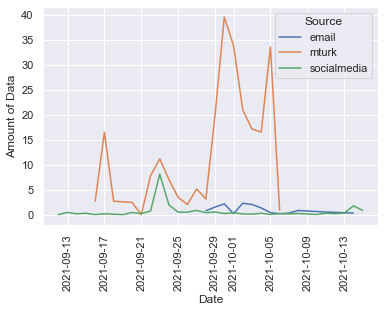

In [53]:
# Or we could plot the data collected per day.
# You might need to pip install matplotlib, pandas and seaborn for this.


import matplotlib.pyplot as plt
import pandas
import seaborn as sns
sns.set()

dates = {}
offset = timedelta(hours=4)
for source in all_sources:
    for ep in [e for e in all_episodes if 'source' in e.environment.keyword_data['all'] and e.environment.keyword_data['all']['source'] == source]:
        if (ep.keyword_data['all']['created_on']-offset).date() not in dates:
            dates[(ep.keyword_data['all']['created_on']-offset).date()] = {}
        if source not in dates[(ep.keyword_data['all']['created_on']-offset).date()]:
            dates[(ep.keyword_data['all']['created_on']-offset).date()][source] = ep.keyword_data[P0]['Time played'].total_seconds() / 3600
        else:
            dates[(ep.keyword_data['all']['created_on']-offset).date()][source] += ep.keyword_data[P0]['Time played'].total_seconds() / 3600
dates_list = []
for d in dates.keys():
    for source in dates[d].keys():
        dates_list.append([d, source, dates[d][source]])
dates_dataframe = pandas.DataFrame(dates_list, columns=['Date', 'Source', 'Amount of Data'])

plot = sns.lineplot(x='Date', y='Amount of Data', hue='Source', data=dates_dataframe)
# plot.set_yscale("log")
# plt.ylim(0,5)
plt.xticks(rotation=90)
plt.show()
plt.close()